In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import ast
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load your data
# Assuming you have a DataFrame df containing concatenated embeddings and grade_result
df = pd.read_csv("/content/drive/MyDrive/embedding_dataset.csv")  # Adjust the filename accordingly


In [ ]:
class YourModel2(torch.nn.Module):
    def __init__(self):
        super(YourModel2, self).__init__()
        self.fc1 = torch.nn.Linear(768, 256)  # Adjust the size of hidden layers as needed
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 3)    # Output size 3 for classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
concatenated_embeddings = df['concatenated_embeddings'].apply(ast.literal_eval).values.tolist()
concatenated_embeddings = torch.tensor(concatenated_embeddings, dtype=torch.float32)
grade_result = torch.tensor(df['grades_round'].values, dtype=torch.long)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(concatenated_embeddings, grade_result, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Instantiate your model
model = YourModel2()

# Define your loss function for classification
criterion = torch.nn.CrossEntropyLoss()  # Cross Entropy Loss for classification

train_losses = []
train_accuracies = []

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(concatenated_embeddings)
    loss = criterion(outputs, grade_result)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    predicted_labels = torch.argmax(outputs, dim=1)
    correct_predictions = (predicted_labels == grade_result).sum().item()
    total_samples = grade_result.size(0)
    train_accuracy = correct_predictions / total_samples

    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy * 100)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/200], Loss: 1.1099
Epoch [2/200], Loss: 1.1014
Epoch [3/200], Loss: 1.0941
Epoch [4/200], Loss: 1.0863
Epoch [5/200], Loss: 1.0771
Epoch [6/200], Loss: 1.0668
Epoch [7/200], Loss: 1.0548
Epoch [8/200], Loss: 1.0416
Epoch [9/200], Loss: 1.0274
Epoch [10/200], Loss: 1.0128
Epoch [11/200], Loss: 0.9993
Epoch [12/200], Loss: 0.9887
Epoch [13/200], Loss: 0.9828
Epoch [14/200], Loss: 0.9828
Epoch [15/200], Loss: 0.9866
Epoch [16/200], Loss: 0.9898
Epoch [17/200], Loss: 0.9895
Epoch [18/200], Loss: 0.9863
Epoch [19/200], Loss: 0.9815
Epoch [20/200], Loss: 0.9765
Epoch [21/200], Loss: 0.9719
Epoch [22/200], Loss: 0.9682
Epoch [23/200], Loss: 0.9655
Epoch [24/200], Loss: 0.9635
Epoch [25/200], Loss: 0.9619
Epoch [26/200], Loss: 0.9603
Epoch [27/200], Loss: 0.9582
Epoch [28/200], Loss: 0.9555
Epoch [29/200], Loss: 0.9522
Epoch [30/200], Loss: 0.9483
Epoch [31/200], Loss: 0.9440
Epoch [32/200], Loss: 0.9393
Epoch [33/200], Loss: 0.9347
Epoch [34/200], Loss: 0.9299
Epoch [35/200], Loss: 0

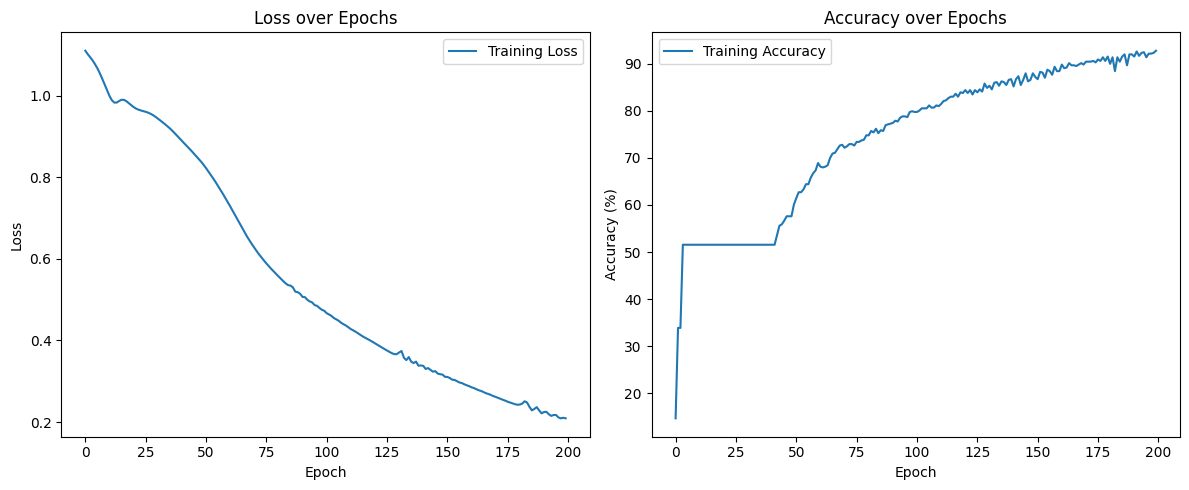

In [ ]:
import matplotlib.pyplot as plt

# Plotting training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test your model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print('Accuracy on test set:',(correct/total)*100)

Accuracy on test set: 93.07692307692308


In [ ]:
# Test your model and collect predictions
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(batch_y.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_targets, all_predictions)


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # It's important to always use integer division
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


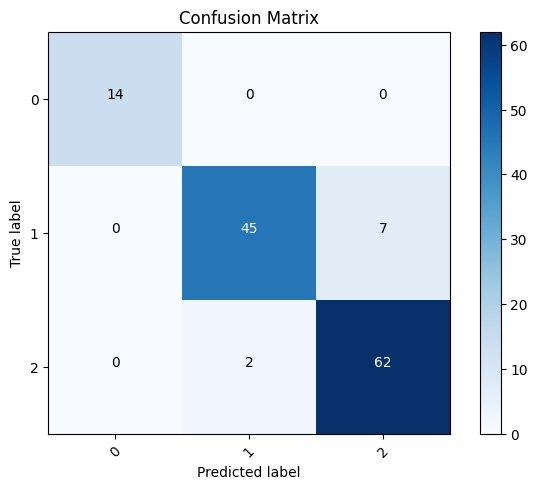

In [ ]:
# Assuming your classes are 0, 1, and 2
class_names = [0, 1, 2]
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')